# Features creation
In this notebook, raw data is loaded and parsed in order to have similar data distributions in train and test sets.

After that, some basic features are computed and the results are saved into files.

In [1]:
import numpy as np
import pandas as pd 
from tqdm import tqdm_notebook
import os
import sys
import datetime
import os.path
from calendar import monthrange

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc
from cycler import cycler
import seaborn as sns
%matplotlib inline

from dateutil import rrule
from datetime import date
 
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['#ff0000', '#0000ff',   '#00ffff','#ffA300', '#00ff00', 
     '#ff00ff', '#990000', '#009999', '#999900', '#009900', '#009999'])

rc('font', size=16)
# rc('font',**{'family':'serif','serif':['Computer Modern']})
rc('text', usetex=False)
rc('figure', figsize=(12, 10))
rc('axes', linewidth=.5)
rc('lines', linewidth=1.75)

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
sys.path.append("../src") # Adds directory to python modules path.
from models import utils
from data import distributions

In [3]:
# Configurations
TARGET_LABEL = 'item_cnt_month'
MONTH_INT_LABEL = 'date_block_num'
INDEX_COLUMNS = ['date_block_num', 'shop_id', 'item_id']
LAGS_WINDOWS = [1, 2, 3, 6, 12]
px_operations = ['last']
operations_dict = {
    'item_cnt_day': ['sum', 'min'],
    # 'date': ['first'],
    'item_price': px_operations
}

## Load data

In [4]:
train = utils.load_training(parse_dts=True)
train.sample(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
47129,2013-01-09,0,15,3704,1499.0,1
2436600,2015-02-22,25,57,18431,299.0,1
2358560,2015-01-05,24,38,4338,2899.0,1
1040772,2013-11-09,10,27,14811,349.0,1
423850,2013-04-08,3,31,3619,449.0,1


In [5]:
test = utils.load_test()
test.sample(5)

,ID,shop_id,item_id
51801,51801,26,10937
5155,5155,4,4719
95905,95905,14,20343
191006,191006,46,9206
155903,155903,55,16459


## Data cleaning

In [6]:
# Remove outliers
train = train[train['item_price'] > 0]
train = train[train['item_price'] < 100000]
train = train[train['item_cnt_day'] < 2000]

## Initial Data Parsing
We start by aggregating daily data into monthly data, taking some different measures.

In [7]:
train = train.groupby(INDEX_COLUMNS).agg(operations_dict)
# Parse dataframe
train.columns = ['%s_%s' % c for c in train.columns]
train = train.rename(columns={'item_cnt_day_sum': TARGET_LABEL})
train = train.reset_index()
# Show sample of rows
train.sample(10)

,date_block_num,shop_id,item_id,item_cnt_month,item_cnt_day_min,item_price_last
1091664,20,41,6164,1,1,2199.0
1203455,23,12,15026,1,1,299.0
336333,5,47,10944,1,1,149.0
1206036,23,16,4901,1,1,2399.0
1586537,33,21,10094,1,1,398.0
882277,15,59,5208,1,1,1199.0
1211126,23,21,17108,1,1,499.0
1286765,24,44,5811,1,1,199.0
978494,18,6,18378,1,1,199.0
530032,9,18,9783,1,-1,1349.0


Now, before computing features, the data distributions should be fixed in order to be similar in train and test sets.

In [8]:
# train, test = distributions.fix_distributions(train, test, TARGET_LABEL)
train = distributions.fix_train_distribution(train, TARGET_LABEL)
train['item_cnt_day_min'] = train['item_cnt_day_min'].fillna(0.0)
train['item_cnt_month'] = train['item_cnt_month']

In order to compute features for train and test sets at the same time, it will be appended to the train set.

In [9]:
# Append
test['date_block_num'] = train['date_block_num'].max() + 1
data_df = train.append(test.drop('ID', axis=1), sort=True)
del train
del test

In [10]:
# Downcast data
dtypes = {
    'date_block_num': np.int8,
    'item_cnt_day_min': np.float16,
    'item_id': np.int16,
    'shop_id': np.int8,
    'item_price_last': np.float16,
    'item_cnt_month': np.float32
}
for c, tp in dtypes.items():
    data_df[c] = data_df[c].astype(tp)
    
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 1614236 to 214199
Data columns (total 6 columns):
date_block_num      int8
item_cnt_day_min    float16
item_cnt_month      float32
item_id             int16
item_price_last     float16
shop_id             int8
dtypes: float16(2), float32(1), int16(1), int8(2)
memory usage: 212.2 MB


Now we are in conditions to compute features.

The features can be split into these categories:

    1. Lag features: related to previous sales
    2. Prices features: related to previous prices
    3. Date features: related to current month

In [11]:
def last_true_idx(arr):
    trues = np.argwhere(arr)
    return np.nan if len(trues) == 0 else trues[-1]


def first_true_idx(arr):
    trues = np.argwhere(arr)
    return np.nan if len(trues) == 0 else trues[0]


class Features:
    
    def __init__(self, df):
        self.df = df
        
    def lag_feature(self, column, lags, drop=False):
        for l in lags:
            lag_df = self.df[INDEX_COLUMNS + [column]]
            lag_df[MONTH_INT_LABEL] += l
            lag_df = lag_df.rename(columns={column: '%s_L%s' % (column, l)})
            self.df = self.df.merge(lag_df, on=INDEX_COLUMNS, how='left')
        
        if drop:
            self.drop_column(column)
            
    def drop_column(self, c):
        self.df.drop(c, axis=1, inplace=True)
        
    def mean_encode(self, gb_columns, label, lags):
        month_avg = self.df.groupby(gb_columns)[TARGET_LABEL].mean()
        month_avg.name = label
        month_avg = month_avg.dropna().reset_index()
        self.df = self.df.merge(month_avg, on=gb_columns, how='left')
        self.df[label] = self.df[label].astype(np.float16)
        self.lag_feature(label, lags, drop=True)
        
    def add_price_trend(self, operation, label):
        op_dict = {'item_price_last_L1': operation}
        df = self.df.groupby([MONTH_INT_LABEL, 'item_id']).agg(op_dict)
        df = df.astype(np.float32).unstack().ffill(limit=6)
        df -= df.shift(1)
        df = df.stack()
        df.columns = [label]
        df[label] = df[label].astype(np.float16)
        df = df.reset_index()
        self.df = self.df.merge(df, on=[MONTH_INT_LABEL, 'item_id'], how='left')
        
    def add_cumulative_sales(self, by_column, name, dtype):
        res_df = pd.pivot_table(
            self.df,
            values=TARGET_LABEL,
            index=MONTH_INT_LABEL,
            columns=['shop_id', by_column],
            aggfunc='sum'
        )
        res_df = res_df.clip(lower=0.0).iloc[:-1].cumsum().ffill()
        res_df = res_df.unstack().dropna()
        res_df = res_df[res_df != 0.0]
        res_df.name = name
        res_df = res_df.reset_index()
        on = [c for c in res_df.columns if c != name]
        self.df = self.df.merge(res_df, on=on, how='left')
        # Lag feature by one month
        self.lag_feature(name, [1], drop=True)
        # Final parsing
        lag_name = '%s_L1' % name
        self.df[lag_name] = self.df[lag_name].fillna(0.0).astype(dtype)
    
    def sales_happened(self, idx):
        """ Computes months when there were sales """
        clipped_df = self.df[idx + [MONTH_INT_LABEL, TARGET_LABEL]]
        clipped_df[TARGET_LABEL] = clipped_df[TARGET_LABEL].clip(lower=0.0)
        # Re-shape data
        pt = pd.pivot_table(
            clipped_df,
            index=MONTH_INT_LABEL,
            values=TARGET_LABEL,
            columns=idx,
            aggfunc='sum'
        )
        pt.replace(0.0, np.nan, inplace=True)
        pt.dropna(how='all', axis=1, inplace=True)
        
        return ~pt.isnull()
    
    def apply_sales_func(self, idx, name, func):
        # Get months when there were sales
        pt = self.sales_happened(idx)
        # Compute last true value
        pt = pt.rolling(len(pt), min_periods=0).apply(func, raw=True)
        # Lag one month
        pt = pt.shift(1)
        # Stack all columns
        while isinstance(pt, pd.DataFrame):
            pt = pt.stack()
        # Last parsing
        pt.name = name
        pt = pt.dropna().reset_index()
        pt[name] = pt[MONTH_INT_LABEL] - pt[name]
        # Merge
        self.df = self.df.merge(pt, on=idx + [MONTH_INT_LABEL], how='left')
    
    def add_last_sale(self, idx, name):
        self.apply_sales_func(idx, name, last_true_idx)
        
    def add_first_sale(self, idx, name):
        self.apply_sales_func(idx, name, first_true_idx)

    @property
    def last_month(self):
        return self.df['date_block_num'].max()
    
    @property
    def train(self):
        return self.df[self.df['date_block_num'] < self.last_month]
    
    @property
    def test(self):
        return self.df[self.df['date_block_num'] == self.last_month].drop(TARGET_LABEL, axis=1)


In [12]:
data = Features(data_df)
del data_df

## Item categories
Add item categories features to the features DataFrame

In [13]:
# Load files
data_dir = utils.get_data_dir()
items_dtype = {
    'item_id': np.int16, 'item_category_id': np.int8,
    'in_PC': np.float16, 'in_version': np.float16, 'icn_games': np.float16,
    'type_code': np.int8, 'subtype_code': np.int8,
    'meta_cat': np.int8
}
shops_dtype = {
    'shop_id': np.int8,
    'sn_Moscow': np.float16,
    'city_code': np.int8,
}
items = pd.read_csv(data_dir + '/processed/items.csv', dtype=items_dtype)
shops = pd.read_csv(data_dir + '/processed/shops.csv', dtype=shops_dtype)

In [14]:
data.df = data.df.merge(items, on='item_id', how='left')
data.df = data.df.merge(shops, on='shop_id', how='left')

## Lag features
Let's create columns with lag features, i.e., with value of sales n months before current month.

In [15]:
%%time
data.lag_feature(TARGET_LABEL, LAGS_WINDOWS)

CPU times: user 43.9 s, sys: 16.1 s, total: 60 s
Wall time: 1min


In [16]:
%%time
data.lag_feature('item_cnt_day_min', [1], drop=True)

CPU times: user 8.48 s, sys: 3.8 s, total: 12.3 s
Wall time: 12.3 s


In [50]:
# Downcast
for c in ['%s_L%s' % (TARGET_LABEL, i) for i in LAGS_WINDOWS]:
    data.df[c] = data.df[c].astype(np.float16)

## Cumulative Sales Features

In [17]:
%%time
data.add_cumulative_sales('item_id', name='cum_sales', dtype=np.int16)

CPU times: user 28.6 s, sys: 10.3 s, total: 38.9 s
Wall time: 38.9 s


In [18]:
%%time
data.add_cumulative_sales('item_category_id', name='cum_cat_sales', dtype=np.int32)

CPU times: user 14.5 s, sys: 7.41 s, total: 21.9 s
Wall time: 21.9 s


In [19]:
%%time
data.add_cumulative_sales('meta_cat', name='cum_metacat_sales', dtype=np.int32)

CPU times: user 12.3 s, sys: 5.93 s, total: 18.2 s
Wall time: 18.2 s


## Prices features
Prices features will be, for each pair:
    - minimum price of last month
    - maximum price of last month
    - last price of last month

In [20]:
%%time
col_labels = ['item_price_' + op for op in px_operations]
for c in col_labels:
    # Add lag
    data.lag_feature(c, [1], drop=True)

CPU times: user 6.86 s, sys: 2.78 s, total: 9.64 s
Wall time: 9.64 s


In [21]:
%%time
# Add mean and min item price of previous month
index_cols = [MONTH_INT_LABEL, 'item_id']
px_df = data.df.groupby(index_cols).agg({'item_price_last_L1': ['mean', 'min']})
px_df = px_df.dropna(how='all')
px_df.columns = ['item_px_mean_L1', 'item_px_min_L1']
data.df = data.df.merge(px_df, on=index_cols, how='left')

CPU times: user 5.7 s, sys: 2.02 s, total: 7.72 s
Wall time: 7.72 s


In [22]:
%%time
data.add_price_trend('mean', 'price_mean_trend')
data.add_price_trend('min', 'price_min_trend')

CPU times: user 13.4 s, sys: 6.12 s, total: 19.5 s
Wall time: 19.5 s


## Date features

In [23]:
# Add month
data.df['month'] = data.df[MONTH_INT_LABEL].apply(lambda m: 1 + m % 12)
data.df['month'] = data.df['month'].astype(np.int8)

In [24]:
m_range = {}
m_weekdays = {}
for yy in [2013, 2014, 2015]:
    m_range[yy] = {}
    m_weekdays[yy] = {}
    for mm in range(1, 12 + 1):
        rng = monthrange(yy, mm)[1]
        m_range[yy][mm] = rng
        # Compute number of week days in month
        start = date(yy, mm, 1)
        end = date(yy, mm, rng)
        weekdays = rrule.rrule(
            rrule.DAILY, byweekday=range(0, 5), dtstart=start, until=end
        )
        m_weekdays[yy][mm] = len(list(weekdays))

m_ranges = [m_range[yy][mm] for yy in [2013, 2014, 2015] for mm in range(1, 12 + 1)]
m_weekend = [
    m_range[yy][mm] - m_weekdays[yy][mm] 
    for yy in [2013, 2014, 2015] for mm in range(1, 12 + 1)
]
data.df['month_range'] = data.df[MONTH_INT_LABEL].map(pd.Series(m_ranges)).astype(np.int8)
data.df['n_weekend'] = data.df[MONTH_INT_LABEL].map(pd.Series(m_weekend)).astype(np.int8)

In [25]:
%%time
data.add_first_sale(['shop_id', 'item_id'], name='first_sale')

CPU times: user 3min 7s, sys: 7.7 s, total: 3min 14s
Wall time: 3min 14s


In [26]:
%%time
data.add_first_sale(['item_id'], name='item_first_sale')

CPU times: user 18.1 s, sys: 3.95 s, total: 22 s
Wall time: 21.6 s


In [27]:
%%time
data.add_last_sale(['item_id'], name='item_last_sale')

CPU times: user 19.2 s, sys: 3.17 s, total: 22.4 s
Wall time: 22.2 s


In [28]:
%%time
data.add_last_sale(['shop_id', 'item_id'], name='last_sale')

CPU times: user 3min 16s, sys: 7.1 s, total: 3min 23s
Wall time: 3min 23s


In [44]:
# Downcast columns
for c in ['first_sale', 'item_first_sale', 'item_last_sale', 'last_sale']:
    data.df[c] = data.df[c].astype(np.float16)

In [45]:
# Test 1
fs_df = data.df[['first_sale', 'item_first_sale']].dropna()
assert (fs_df['first_sale'] <= fs_df['item_first_sale']).eq(True).all()
del fs_df
# Test 2
ls_df = data.df[['last_sale', 'item_last_sale']].dropna()
assert (ls_df['item_last_sale'] <= ls_df['last_sale']).eq(True).all()
del ls_df
# Test 3
df = data.df[['last_sale', 'first_sale']].dropna()
assert (df['first_sale'] >= df['last_sale']).eq(True).all()
del df
# Test 4
df = data.df[['item_last_sale', 'item_first_sale']].dropna()
assert (df['item_first_sale'] >= df['item_last_sale']).eq(True).all()
del df

In [46]:
assert (data.df['first_sale'].dropna() > 0).eq(True).all()
assert (data.df['item_first_sale'].dropna() > 0).eq(True).all()
assert (data.df['item_last_sale'].dropna() > 0).eq(True).all()
assert (data.df['last_sale'].dropna() > 0).eq(True).all()

## Mean Encodings

In [31]:
%%time
# Month lag1 mean encoding
data.mean_encode(['date_block_num'], 'month_avg', [1, 12])

CPU times: user 26.5 s, sys: 12.2 s, total: 38.7 s
Wall time: 38.7 s


In [32]:
%%time
data.mean_encode(['date_block_num', 'item_id'], 'month_item_avg', [1, 2, 3, 6])

CPU times: user 46 s, sys: 21.5 s, total: 1min 7s
Wall time: 1min 7s


In [33]:
%%time
data.mean_encode(['date_block_num', 'shop_id'], 'month_shop_avg', [1, 2, 3, 6])

CPU times: user 46.8 s, sys: 23.4 s, total: 1min 10s
Wall time: 1min 10s


In [34]:
%%time
data.mean_encode(['date_block_num', 'item_category_id'], 'month_cat_avg', [1])

CPU times: user 17 s, sys: 9.03 s, total: 26 s
Wall time: 26 s


In [35]:
%%time
data.mean_encode(['date_block_num', 'shop_id', 'item_category_id'], 'month_shopcat_avg', [1])

CPU times: user 16.7 s, sys: 9.3 s, total: 26 s
Wall time: 26 s


In [36]:
%%time
data.mean_encode(['date_block_num', 'city_code'], 'month_city_avg', [1])

CPU times: user 17.1 s, sys: 10.1 s, total: 27.2 s
Wall time: 27.2 s


In [37]:
%%time
data.mean_encode(['date_block_num', 'item_id', 'city_code'], 'month_itemcity_avg', [1])

CPU times: user 23.6 s, sys: 11.9 s, total: 35.6 s
Wall time: 35.6 s


## Features correlations

In [38]:
corrs = data.df.sample(2**22).corr()

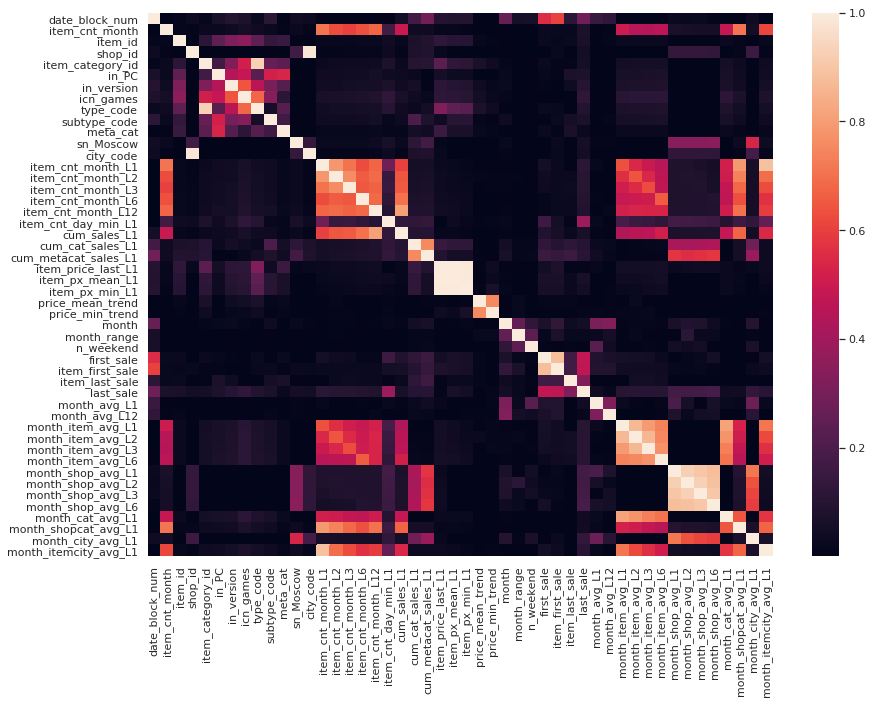

In [39]:
sns.set(rc={'figure.figsize':(14, 10)})
sns.heatmap(corrs.abs())

# Save features
Finally, split into train and test and save to hdf5 files.

In [51]:
data.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 48 columns):
date_block_num           int8
item_cnt_month           float32
item_id                  int16
shop_id                  int8
item_category_id         int8
in_PC                    float16
in_version               float16
icn_games                float16
type_code                int8
subtype_code             int8
meta_cat                 int8
sn_Moscow                float16
city_code                int8
item_cnt_month_L1        float16
item_cnt_month_L2        float16
item_cnt_month_L3        float16
item_cnt_month_L6        float16
item_cnt_month_L12       float16
item_cnt_day_min_L1      float16
cum_sales_L1             int16
cum_cat_sales_L1         int32
cum_metacat_sales_L1     int32
item_price_last_L1       float16
item_px_mean_L1          float16
item_px_min_L1           float16
price_mean_trend         float16
price_min_trend          float16
month                  

In [52]:
# Save to HDF5 files
data_path = '../data/processed/'
data.train.to_hdf(data_path + 'train_features.h5', key='df', mode='w')
data.test.to_hdf(data_path + 'test_features.h5', key='df', mode='w')